# Reinforcement learning for robotics
This is the initial notebook that you will need to fill out through the semester. 
### Setup
First let's make sure that everything is working properly:

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
assert gym.__version__=='1.0.0',"You need a newer version of gym"
print("Everything seems good")

Everything seems good


### Outline
As teaching a robot how to walk is tricky, you will first test your algorithm on a much simpler task: Balancing an inverted pendulum.
This week, you will:
- Setup a first enviromnent
- Run a random policy
- Modify the distribution of this policy

In [4]:
#create the environment
envname="InvertedPendulum-v5"
env = gym.make_vec(envname,1,render_mode='rgb_array',vectorization_mode='sync')

This environment is called InvertedPendulum, and is running in the Mujoco simulator. You can check what it can do by reading the [documentation](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/)

Your first task is to find what are the state space and the action space. Additionally, answer the following questions:
- What is the dimension of the state space?
- What is the dimension of the action space?
- How could you get these dimentions directly in your code?
- When your ran these commands, you should have gotten an array of dimension 2. What does each of the dimension represent?

_Answers_: - What is the dimension of the state space? 4
- What is the dimension of the action space? 1   

In [7]:
obs, info = env.reset()
print("State space dimension:", env.single_observation_space.shape)
print("Action space dimension:", env.single_action_space.shape)

State space dimension: (4,)
Action space dimension: (1,)


### Visualization
Gymnasium is providing a visualisation function, let's try it

In [9]:
def render_notebook(env,id,title=""):
    clear_output(wait=True)
    plt.imshow(env.render()[id])
    plt.axis('off')
    plt.tight_layout()
    plt.title(title)
    plt.show()
    plt.pause(0.1)

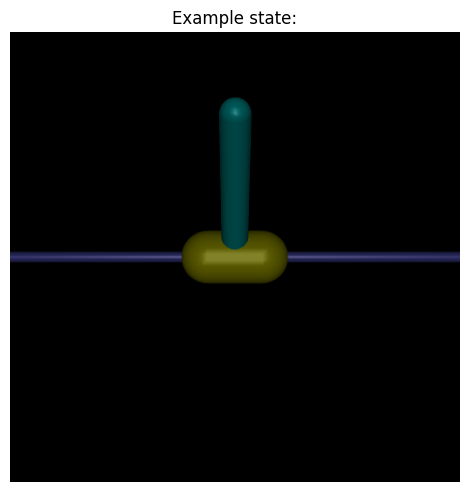

In [9]:
obs, info = env.reset()
render_notebook(env, 0, "Example state:")


Nice right?

### Random policy
Now you will try to implement a random policy: Uniformely chose a random action at each time step.

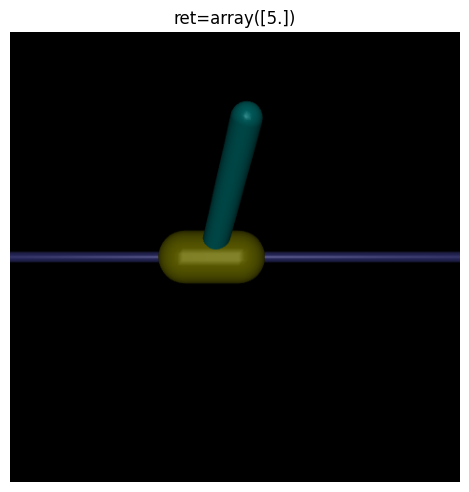

In [10]:
terminated = [False]
env.reset()
ret=0
while not all(terminated):
    action = np.random.uniform(-3, 3, size=(1, 1))
    _,reward, terminated,truncated,info = env.step(action)
    terminated = terminated|truncated
    ret+=reward
    render_notebook(env,0,f"{ret=}")

### Other distribution
This policy is quite terrible, so let's try to improve it by using a gaussian distribution instead. Test several standard deviations and see which one works best

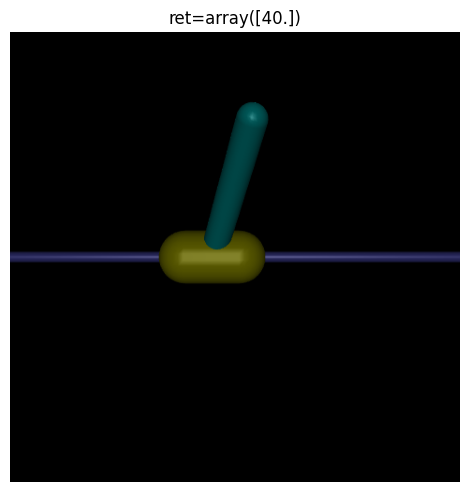

In [11]:

terminated = [False]
std = 0.1
env.reset()
ret=0
while not all(terminated):
    action = np.random.normal(0, std, size=(1, 1))
    _,reward, terminated,truncated,info = env.step(action)
    terminated = terminated|truncated
    ret+=reward
    render_notebook(env,0,f"{ret=}")

This concludes this first part of the project, next week we will try to implement a feedback controler in this system. 
In the meantime, feel free to get more confortable with the documentation of gymnasium

FeedBack Policy u=-Kx avec K a determiner

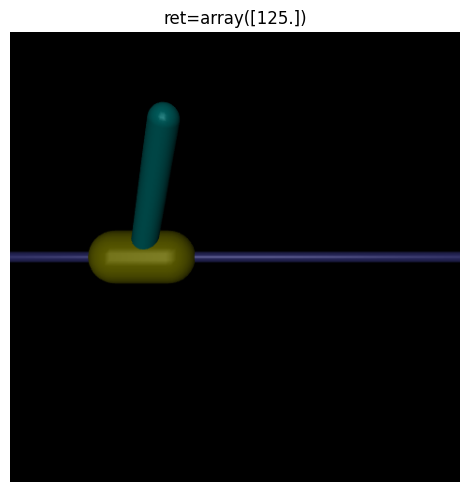

In [12]:
K = np.array([[-1.0 , -2.0, -3.0, -4.0]]) 
terminated = [False]
env.reset()
ret=0
while not all(terminated):
    action = -np.dot(K, obs.T)
    obs,reward, terminated,truncated,info = env.step(action)
    terminated = terminated|truncated
    ret+=reward
    render_notebook(env,0,f"{ret=}")
    

In [13]:
def simulate(K):
    obs, info = env.reset()
    terminated = [False]
    ret = 0
    while not all(terminated):
        action = -np.dot(K, obs.T)
        obs, reward, terminated, truncated, info = env.step(action)
        terminated = terminated | truncated
        ret += reward
    return ret

bret = -np.inf  
bK = None
num = 10000
for i in range(num):
    K_cand = np.random.uniform(low=-5, high=5, size=(1, 4))
    cret = simulate(K_cand)
    if cret > bret:
        bret = cret
        bK = K_cand 
    if np.isclose(cret.item(), 1000.0):
        print(f"Iteration {i}: reward = {cret}, best reward = {bret}")
        break
    print(f"Iteration {i}: reward = {cret}, best reward = {bret}")

print(f"Best K found : {bK}", f"best Reward = {bret}")


Iteration 0: reward = [59.], best reward = [59.]
Iteration 1: reward = [5.], best reward = [59.]
Iteration 2: reward = [19.], best reward = [59.]
Iteration 3: reward = [5.], best reward = [59.]
Iteration 4: reward = [86.], best reward = [86.]
Iteration 5: reward = [5.], best reward = [86.]
Iteration 6: reward = [30.], best reward = [86.]
Iteration 7: reward = [23.], best reward = [86.]
Iteration 8: reward = [99.], best reward = [99.]
Iteration 9: reward = [58.], best reward = [99.]
Iteration 10: reward = [4.], best reward = [99.]
Iteration 11: reward = [20.], best reward = [99.]
Iteration 12: reward = [8.], best reward = [99.]
Iteration 13: reward = [36.], best reward = [99.]
Iteration 14: reward = [15.], best reward = [99.]
Iteration 15: reward = [5.], best reward = [99.]
Iteration 16: reward = [6.], best reward = [99.]
Iteration 17: reward = [15.], best reward = [99.]
Iteration 18: reward = [46.], best reward = [99.]
Iteration 19: reward = [259.], best reward = [259.]
Iteration 20: r

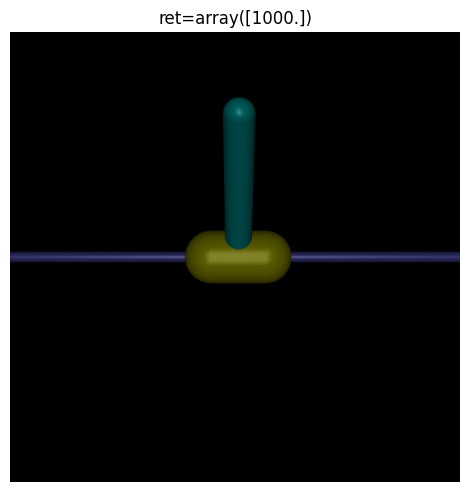

In [14]:
obs, info = env.reset()
terminated = [False]
ret = 0

while not all(terminated):
    action = -np.dot(bK, obs.T)
    obs, reward, terminated, truncated, info = env.step(action)
    terminated = terminated | truncated
    ret += reward
    render_notebook(env, 0, f"{ret=}")

In [43]:
state_dim = 4
action_dim = 1

# Initialize policy parameters
theta = np.random.randn(state_dim,action_dim ) * 0.01
alpha = 0.01  # Learning rate
gamma = 0.99  # Discount factor
best_reward = -np.inf  # Initialize best reward to negative infinity
best_theta = None  # Initialize best theta

# linear/gaussian policy
def policy(state):
    mean_action = np.dot(state, theta).item()
    return np.random.normal(mean_action, scale=0.2)

def compute_log_gradient(state, action):
    mean_action = np.dot(state, theta)  # Scalar value
    return (action - mean_action) * state.reshape(-1, 1)  # Reshape state to (4, 1)  # Gradient of log-probability for Gaussian policy

# Training loop
for episode in range(5000):
    state, _ = env.reset()
    states, actions, rewards = [], [], []
    total_reward = 0
    done = False

    while not done:
        action_scalar = np.clip(policy(state), -3, 3)  # Get action from the policy
        action = np.array([[action_scalar]])  # Reshape to (1, 1)
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated

        # Store trajectory
        states.append(state)
        actions.append(action_scalar)  # Store scalar action for gradient calculation
        rewards.append(reward)
        
        total_reward += reward
        state = next_state

    # Update best theta if this episode's reward is the highest so far
    if total_reward >= best_reward:
        best_reward = total_reward
        best_theta = theta.copy()  # Save a copy of the current theta

    # Compute returns
    returns = np.zeros(len(rewards))
    G = 0
    for t in reversed(range(len(rewards))):
       G = rewards[t] + gamma * G
       returns[t] = G
    alpha = 0.0005 / (1 + 0.00005 * episode)  # Decay learning rate 
    # Policy gradient update
    for t in range(len(states)):
       grad = compute_log_gradient(states[t], actions[t])  # Gradient of log-probability
       theta += alpha * grad * returns[t]  # Gradient ascent

    print(f"Episode {episode}, Total Reward: {total_reward}, Best Reward: {best_reward}, theta:{theta}" )
# Save trained parameters
theta = best_theta
np.save('trained_theta.npy', theta)

C:\Users\kello\AppData\Local\Temp\ipykernel_23432\1688170494.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  returns[t] = G


Episode 0, Total Reward: [9.], Best Reward: [9.], theta:[[ 0.00455704]
 [ 0.00293048]
 [ 0.00655661]
 [-0.00257868]]
Episode 1, Total Reward: [11.], Best Reward: [11.], theta:[[ 0.00455556]
 [ 0.00297369]
 [ 0.00645876]
 [-0.00233009]]
Episode 2, Total Reward: [8.], Best Reward: [11.], theta:[[ 0.004591  ]
 [ 0.00292044]
 [ 0.00661297]
 [-0.00273135]]
Episode 3, Total Reward: [13.], Best Reward: [13.], theta:[[ 0.00457748]
 [ 0.00296041]
 [ 0.00648988]
 [-0.00240298]]
Episode 4, Total Reward: [15.], Best Reward: [15.], theta:[[ 0.00460905]
 [ 0.00288599]
 [ 0.00662558]
 [-0.00281224]]
Episode 5, Total Reward: [42.], Best Reward: [42.], theta:[[0.00519909]
 [0.00332558]
 [0.00710131]
 [0.00016595]]
Episode 6, Total Reward: [15.], Best Reward: [42.], theta:[[ 0.00526089]
 [ 0.0033024 ]
 [ 0.00736524]
 [-0.00025132]]
Episode 7, Total Reward: [19.], Best Reward: [42.], theta:[[0.00523826]
 [0.0033508 ]
 [0.00672861]
 [0.00110397]]
Episode 8, Total Reward: [18.], Best Reward: [42.], theta:[

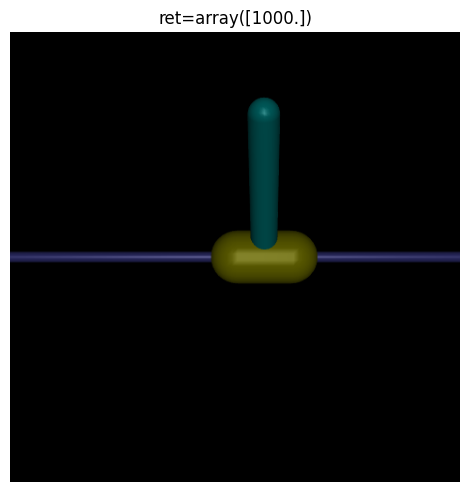

In [44]:
# Load trained parameters
theta = np.load('trained_theta.npy')

obs, info = env.reset()
terminated = [False]
ret = 0

while not all(terminated):
    action_scalar = policy(obs)  # Get action from the trained policy
    action = np.array([[action_scalar]])
    obs, reward, terminated, truncated, info = env.step(action)
    terminated = terminated | truncated
    ret += reward
    render_notebook(env, 0, f"{ret=}")